In [1]:
suppressPackageStartupMessages(library(dplyr))
library(readr)
library(ggplot2); theme_set(theme_classic(base_size=14))

simulate_example <- function(
    n,
    mean_coef = c(pgs = 0.5, ancestry = 0.4, age=-0.4, sex=0.5), 
    sd_coef = c(intercept = log(7 / 3), ancestry = 0.2, age = -0.15, sex = 0.5)
) {
    # simulate raw data
    data <- data.frame(
        pgs = rnorm(n),
        intercept = 1,
        ancestry = runif(n),
        age = rnorm(n, 40, 10),
        sex = rbinom(n, size = 1, prob = 0.5)
    )
    # create interpretable labels
    data <- data %>% mutate(
        ancestry_label = cut_number(ancestry, 5, labels = FALSE),
        age_label = cut_number(age, 5, labels = FALSE),
        sex_label = ifelse(sex > 0, "Female", "Male")
    )
    # standardize variables
    data[, c("ancestry", "age", "sex")] <- scale(data[, c("ancestry", "age", "sex")])

    # simulate phenotype
    mean_mat <- as.matrix(data[, names(mean_coef)])
    sd_mat <- as.matrix(data[, names(sd_coef)])
    
    y_mean <- mean_mat %*% mean_coef
    y_sd <- sqrt(exp(sd_mat %*% sd_coef))
    y <- rnorm(n = n, mean = y_mean, sd = y_sd)
    data[, "pheno"] <- y

    # pheno <- sort(rnbinom(n, mu = 120, size = 10))
    # data[, "pheno"] <- pheno[rank(data[, "y"], ties.method = "first")]
    data <- cbind(personid=paste0("indiv", seq(1, nrow(data))), data)
    return(data)
}

In [2]:
set.seed(1234)
data_df <- simulate_example(n=1000)

write_tsv(
    data_df %>% mutate_if(is.numeric, round, digits = 3), 
    "trait.tsv"
)

In [3]:
system(
    "Rscript ../calpred.cli.R --y_col pheno --df trait.tsv --mean_cols pgs,ancestry,age,sex --sd_cols ancestry,age,sex --out_prefix trait"
)

In [4]:
coef_df <- read_tsv("trait.coef.tsv", show_col_types = FALSE)
pred_df <- read_tsv("trait.fitted.tsv", show_col_types = FALSE)
pred_df[, "pheno"] <- data_df[, "pheno"]

In [5]:
coef_df

name,mean_coef,mean_se,sd_coef,sd_se
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
const,-0.01378506,0.05086959,0.8351352,0.04483364
pgs,0.49407466,0.04533305,NA,NA
ancestry,0.37292734,0.04526474,0.1544514,0.04505185
age,-0.42640370,0.04611310,-0.1695323,0.04501991
sex,0.50386137,0.04983875,0.4406440,0.04496541


In [6]:
# Calculate the quantiles
q5 <- quantile(pred_df[["pheno"]], probs = 0.95)
q5_mean <- quantile(pred_df[["pheno"]] - pred_df[["mean"]], probs = 0.95)
q5_mean_sd <- quantile((pred_df[["pheno"]] - pred_df[["mean"]]) / pred_df[["sd"]], probs = 0.95)

pred_df <- pred_df %>%
  mutate(
    top_q5 = pheno >= q5,
    top_q5_mean = (pheno - mean) >= q5_mean,
    top_q5_mean_sd = ((pheno - mean) / sd) >= q5_mean_sd
  )


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




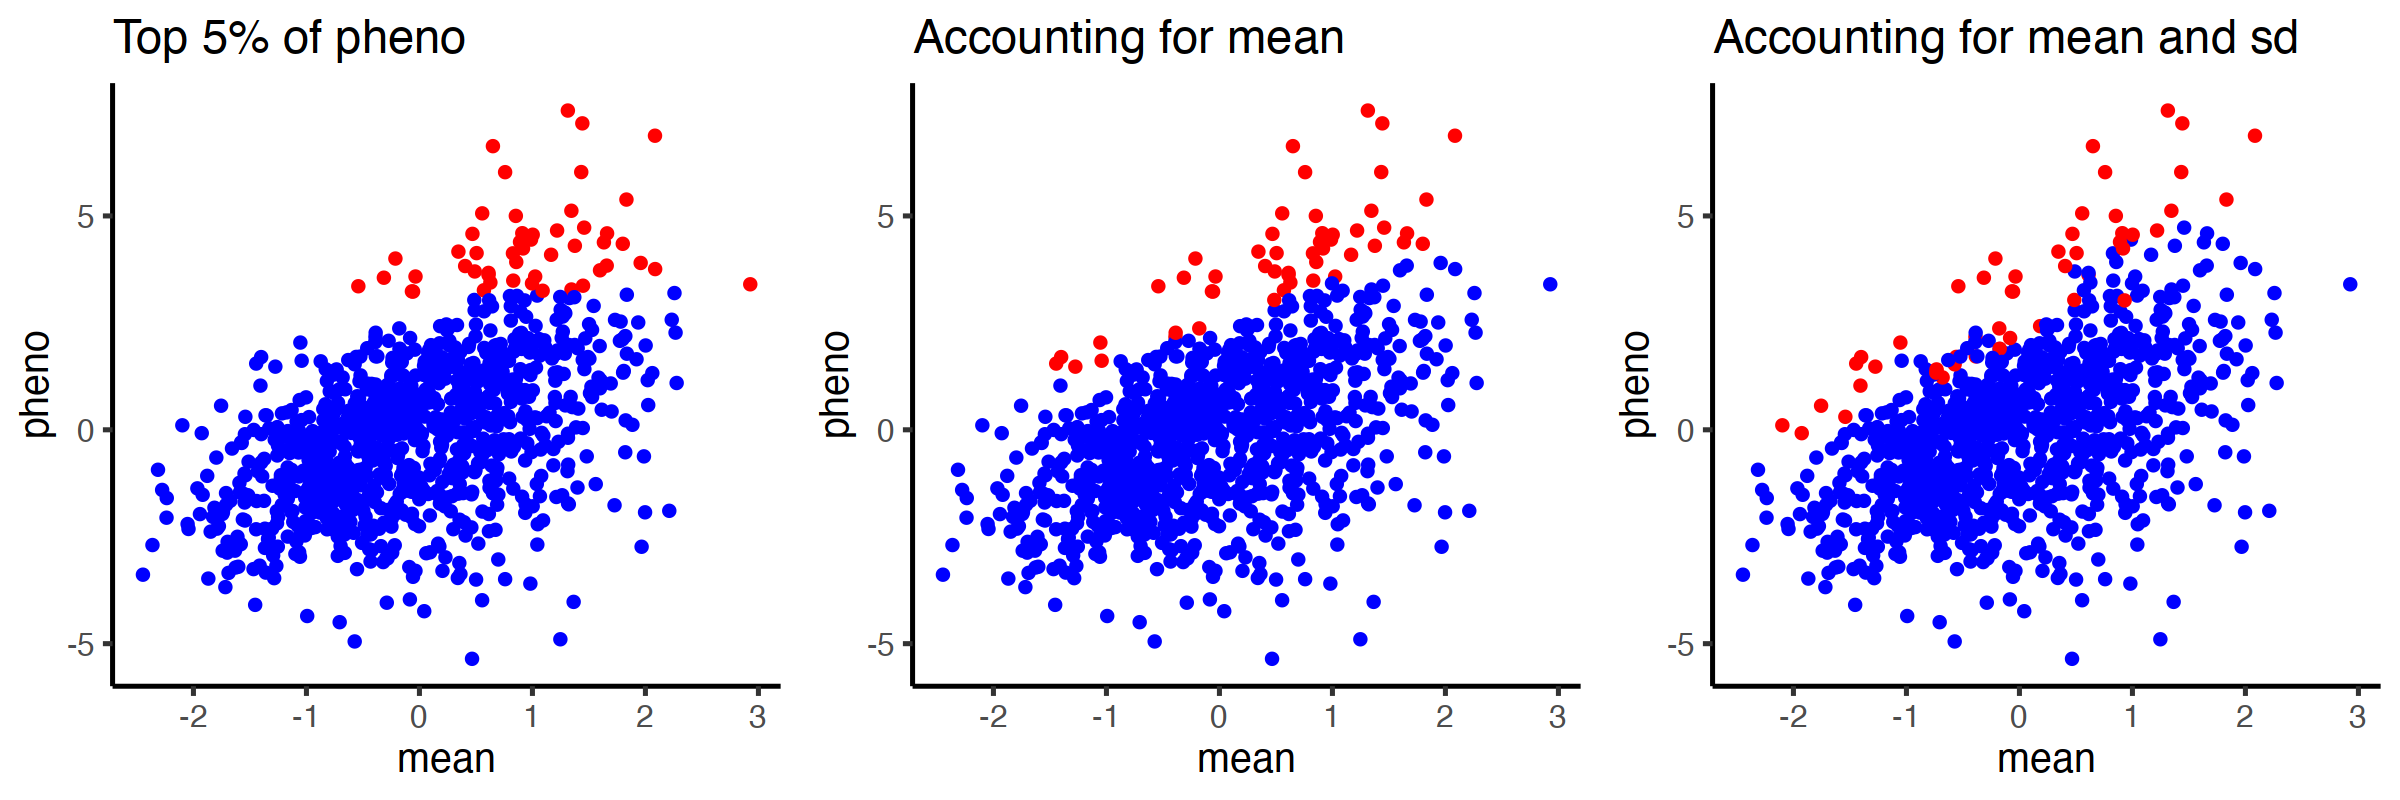

In [7]:
plot1 <- ggplot(pred_df, aes(x = mean, y = pheno, color = top_q5)) +
  geom_point() +
  scale_color_manual(values = c("FALSE" = "blue", "TRUE" = "red")) +
  labs(title = "Top 5% of pheno") + 
  theme(legend.position = "none")

plot2 <- ggplot(pred_df, aes(x = mean, y = pheno, color = top_q5_mean)) +
  geom_point() +
  scale_color_manual(values = c("FALSE" = "blue", "TRUE" = "red")) +
  labs(title = "Accounting for mean") +
  theme(legend.position = "none")

plot3 <- ggplot(pred_df, aes(x = mean, y = pheno, color = top_q5_mean_sd)) +
  geom_point() +
  scale_color_manual(values = c("FALSE" = "blue", "TRUE" = "red")) +
  labs(title = "Accounting for mean and sd") +
  theme(legend.position = "none")
  

# Display the plots
library(gridExtra)
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)
grid.arrange(plot1, plot2, plot3, ncol = 3)